In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# show pytorch version
print("PyTorch Version:", torch.__version__)

# device config stuff (CUDA for gpu, otherwise CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

PyTorch Version: 2.6.0+cu124
cuda


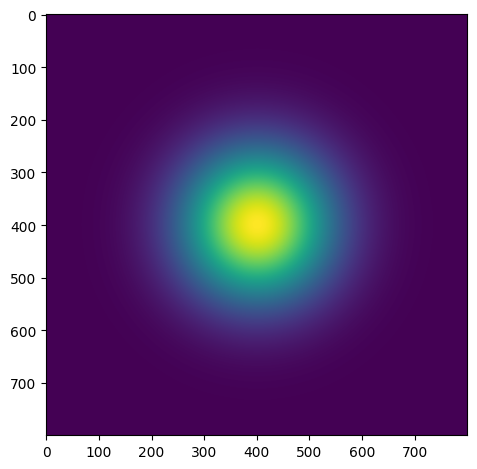

In [2]:
# create coord grid
# np.mgrid creates two 2D arrays:
#   X contains the x-coordinate for each point
#   Y contains the y-coordinate for each point
# coords range from -4.0 to 4.0 with a step of 0.01
X, Y = np.mgrid[-4.0:4:0.01, -4.0:4:0.01]

# load into pytorch sensors
# in pyTorch:
#   - A tensor is like a NumPy array, but it can live on the GPU
#   - Tensors can be part of a computational graph (used in deep learning)
x = torch.Tensor(X).to(device) # move to device (GPU or CPU)
y = torch.Tensor(Y).to(device)

# Compute Gaussian: e^(-(x^2 + y^2) / 2)
# - Produces a smooth "hill" shape centered at (0,0)
z = torch.exp(-(x**2 + y**2) / 2.0)

# Plot the result
plt.imshow(z.cpu().numpy()) # Move to CPU & convert to NumPy before plotting
plt.tight_layout()
plt.show()

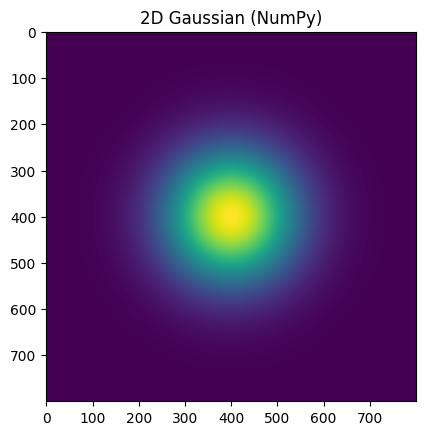

In [3]:
# numpy + matplotlib version
# Compute Gaussian: e^(-(x^2 + y^2) / 2)
gaussian_numpy = np.exp(-(X**2 + Y**2) / 2.0)

# Plot the Gaussian
plt.imshow(gaussian_numpy)
plt.title("2D Gaussian (NumPy)")
plt.show()

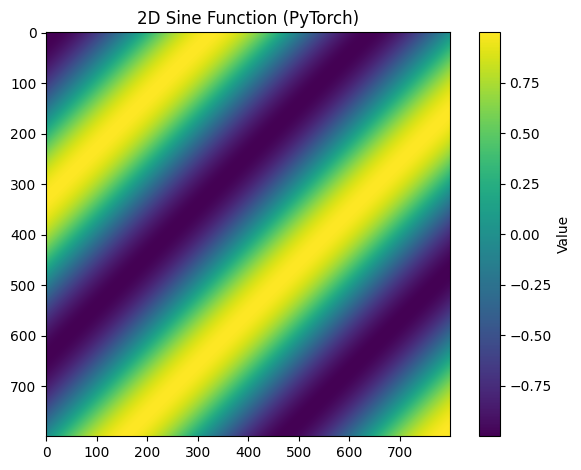

In [4]:
# Reuse the same grid X, Y
# Convert to PyTorch tensors on the device (same pattern)
x = torch.Tensor(X).to(device)
y = torch.Tensor(Y).to(device)

# 2D sine function: angle depends on x and y coordinates
sine_torch = torch.sin(x + y)

# Plot the sine stripes
# to correctly implement the axis values, can use extent as an arg to imshow(extent=(-4, 4, -4, 4))
plt.imshow(sine_torch.cpu().numpy())
plt.title("2D Sine Function (PyTorch)")
plt.colorbar(label='Value')
plt.tight_layout()
plt.show()

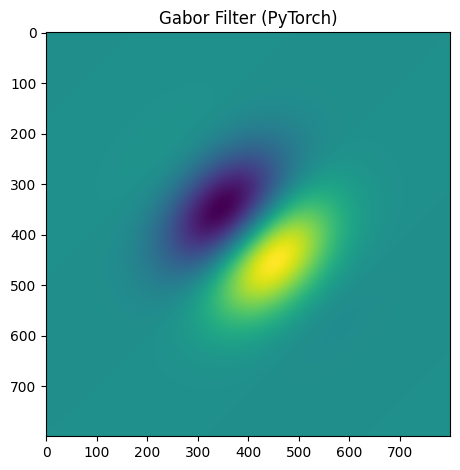

In [5]:
gabor = z * sine_torch
# Plot the Gabor filter
plt.imshow(gabor.cpu().numpy())
plt.title("Gabor Filter (PyTorch)")
plt.tight_layout()
plt.show()


/tmp/ipython-input-1282541039.py:45: ComplexWarning: Casting complex values to real discards the imaginary part
  a = np.uint8(np.clip(a, 0, 255))


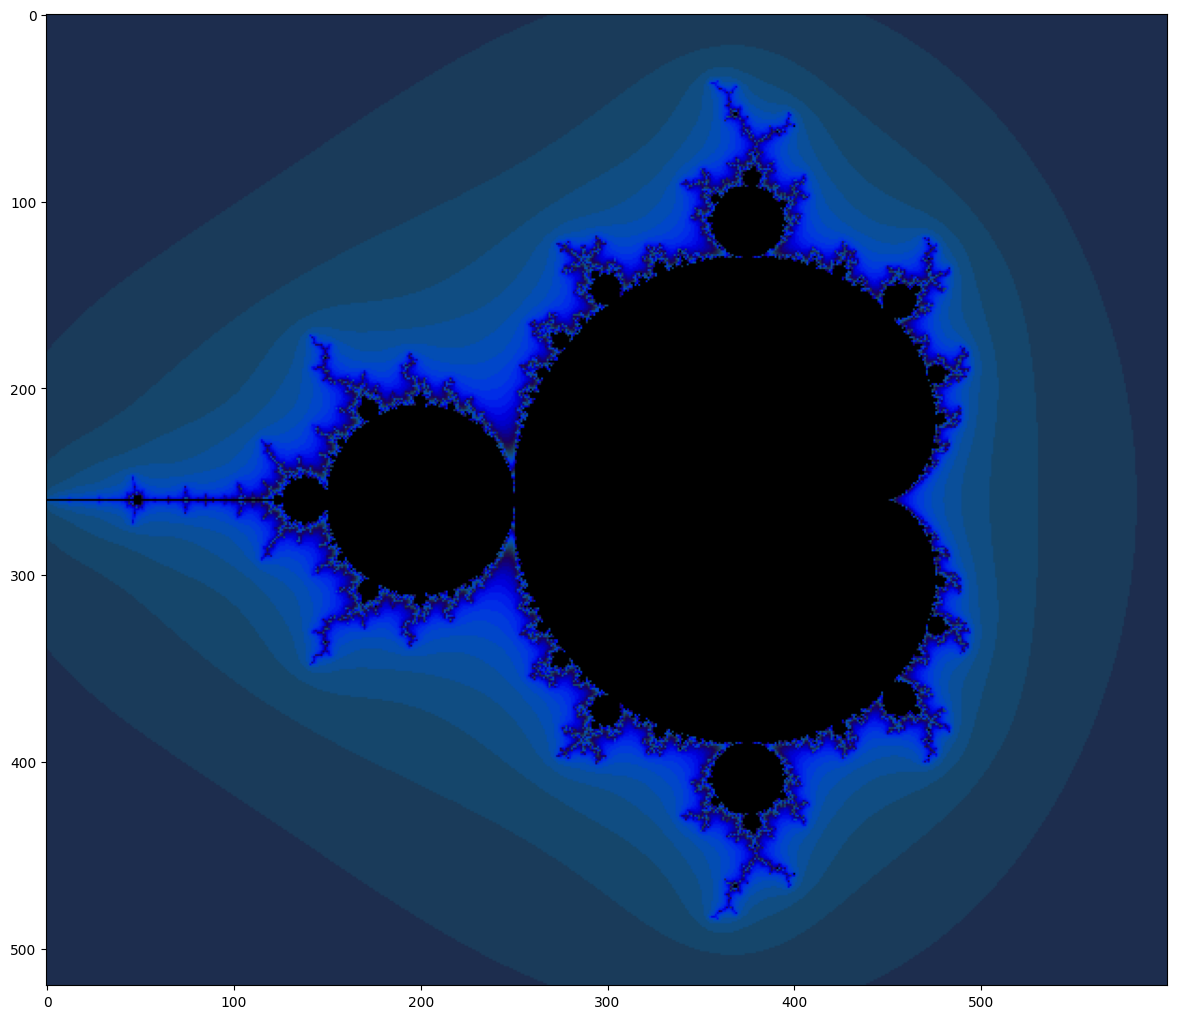

In [6]:
import torch
import numpy as np
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Use NumPy to create a 2D array of complex numbers on [-2,2]x[-2,2]
# create grid of x in [-2, 1], y in [-1.3, 1.3]
Y, X = np.mgrid[-1.3:1.3:0.005, -2:1:0.005]

# load into PyTorch tensors
x = torch.Tensor(X)
y = torch.Tensor(Y)
z = torch.complex(x, y)          # c = x + i y (the constant for each pixel)
zs = z.clone()                   # working variable that will hold z_n
ns = torch.zeros_like(z)         # counter/“escape time” proxy

# transfer to the GPU device
z = z.to(device)
zs = zs.to(device)
ns = ns.to(device)


for i in range(200):
    #Compute the new values of z: z^2 + x
    zs_ = zs*zs + z
    #Have we diverged with this new value?
    not_diverged = torch.abs(zs_) < 4.0
    #Update variables to compute
    ns += not_diverged
    zs = zs_


#plot
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(16,10))
def processFractal(a):
    """Display an array of iteration counts as a
    colorful picture of a fractal."""
    a_cyclic = (6.28*a/20.0).reshape(list(a.shape)+[1])
    img = np.concatenate([10+20*np.cos(a_cyclic),
    30+50*np.sin(a_cyclic),
    155-80*np.cos(a_cyclic)], 2)
    img[a==a.max()] = 0
    a = img
    a = np.uint8(np.clip(a, 0, 255))
    return a

plt.imshow(processFractal(ns.cpu().numpy()))
plt.tight_layout(pad=0)
plt.show()



Chat version

Using device: cuda
Generating a single Mandelbrot image...


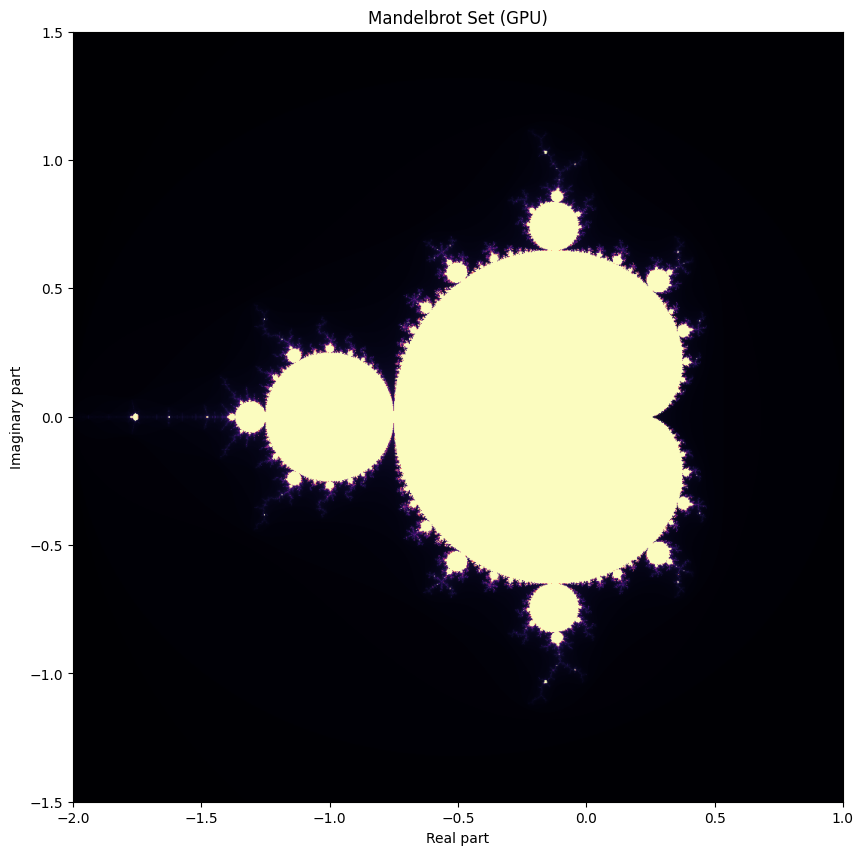

In [7]:
import torch
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Check for GPU and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Function to generate the Mandelbrot set
def mandelbrot_gpu(x_min, x_max, y_min, y_max, width, height, max_iter, power=2):
    """
    Generates the Mandelbrot set on the GPU using PyTorch.

    Args:
        x_min (float): The minimum x-coordinate of the complex plane.
        x_max (float): The maximum x-coordinate of the complex plane.
        y_min (float): The minimum y-coordinate of the complex plane.
        y_max (float): The maximum y-coordinate of the complex plane.
        width (int): The width of the output image in pixels.
        height (int): The height of the output image in pixels.
        max_iter (int): The maximum number of iterations.
        power (int): The power of the complex number for the Mandelbrot formula (default is 2).

    Returns:
        torch.Tensor: A tensor representing the iteration count for each pixel.
    """
    # Create grid of complex numbers on the GPU
    x = torch.linspace(x_min, x_max, width, device=device)
    y = torch.linspace(y_min, y_max, height, device=device)
    c = x[None, :] + 1j * y[:, None]

    z = torch.zeros_like(c)
    divergence_count = torch.zeros(height, width, dtype=torch.int32, device=device)
    mask = torch.ones(height, width, dtype=torch.bool, device=device)

    for i in range(max_iter):
        if not mask.any():
            break

        z[mask] = z[mask]**power + c[mask]
        divergence = torch.abs(z) > 2
        newly_diverged = divergence & mask
        divergence_count[newly_diverged] = i + 1
        mask &= ~divergence

    # If a pixel never diverged, set its iteration count to max_iter
    divergence_count[mask] = max_iter
    return divergence_count


# --- Parameters for generation and visualization ---
# Initial view
x_min, x_max = -2.0, 1.0
y_min, y_max = -1.5, 1.5

# Image dimensions
width = 1024
height = 1024

# Maximum iterations
max_iter = 256

# --- Generate and display a single frame ---
print("Generating a single Mandelbrot image...")
mandelbrot_image = mandelbrot_gpu(x_min, x_max, y_min, y_max, width, height, max_iter)

# Convert the tensor to a numpy array for plotting
mandelbrot_np = mandelbrot_image.cpu().numpy()

# Plot the image
plt.figure(figsize=(10, 10))
plt.imshow(mandelbrot_np, cmap='magma', extent=[x_min, x_max, y_min, y_max])
plt.title("Mandelbrot Set (GPU)")
plt.xlabel("Real part")
plt.ylabel("Imaginary part")
plt.show()


Updated version (more detail)


x step is: 0.000125, y step is: -0.00015000000000000001


/tmp/ipython-input-2431559382.py:60: ComplexWarning: Casting complex values to real discards the imaginary part
  a = np.uint8(np.clip(a, 0, 255))


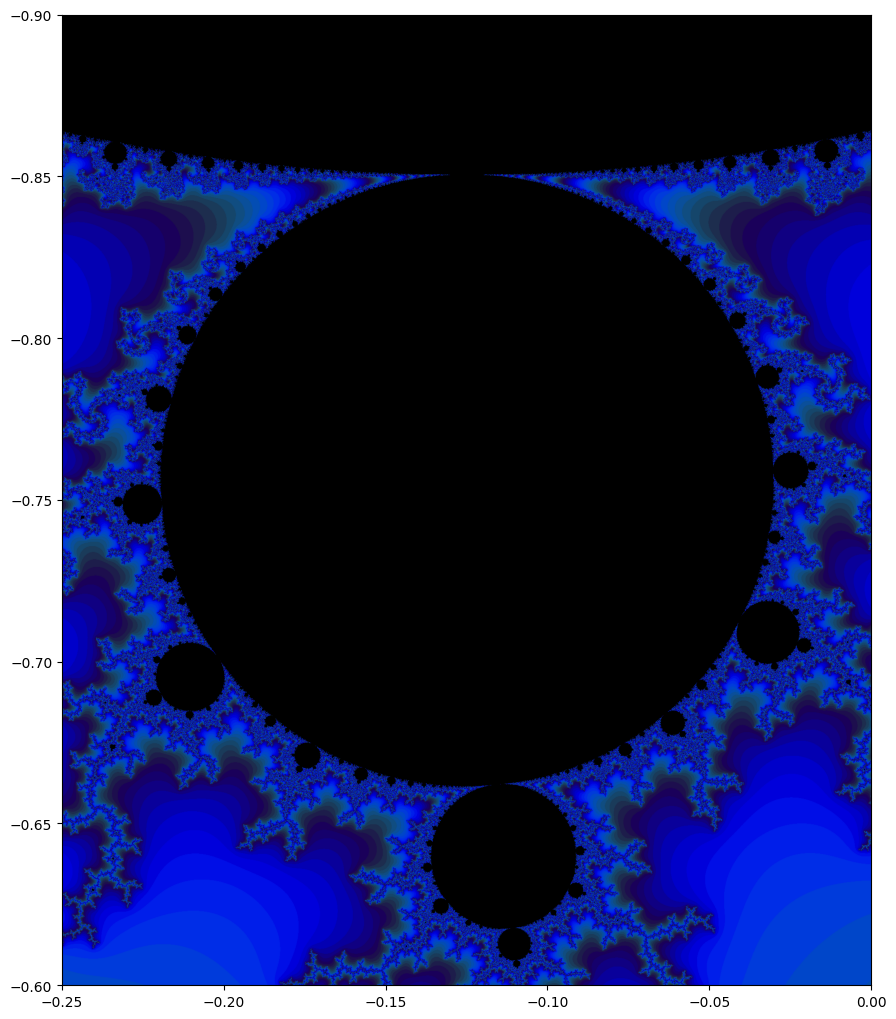

In [8]:
import torch
import numpy as np
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

x_min, x_max = -0.25, 0.0
y_min, y_max = -0.6, -0.9

# image res (higher for more detail, but slower)
width = 2000
height = 2000

# higher iterations capture more detail, but take longer and use more memory
max_iter = 1000

# calc  step size based on the coord range and res.
x_step = (x_max - x_min) / width
y_step = (y_max - y_min) / height
print(f'x step is: {x_step}, y step is: {y_step}')



Y, X = np.mgrid[y_min:y_max:y_step, x_min:x_max:x_step]

# load into PyTorch tensors
x = torch.Tensor(X)
y = torch.Tensor(Y)
z = torch.complex(x, y)          # c = x + i y (the constant for each pixel)
zs = z.clone()                   # working variable that will hold z_n
ns = torch.zeros_like(z)         # counter/"escape time" proxy

# transfer to the GPU device
z = z.to(device)
zs = zs.to(device)
ns = ns.to(device)


for i in range(max_iter):
    #Compute the new values of z: z^2 + x
    zs_ = zs*zs + z
    #Have we diverged with this new value?
    not_diverged = torch.abs(zs_) < 4.0
    #Update variables to compute
    ns += not_diverged
    zs = zs_

#plot

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(16,10))
def processFractal(a):
    """Display an array of iteration counts as a
    colorful picture of a fractal."""
    a_cyclic = (6.28*a/20.0).reshape(list(a.shape)+[1])
    img = np.concatenate([10+20*np.cos(a_cyclic),
    30+50*np.sin(a_cyclic),
    155-80*np.cos(a_cyclic)], 2)
    img[a==a.max()] = 0
    a = img
    a = np.uint8(np.clip(a, 0, 255))
    return a

plt.imshow(processFractal(ns.cpu().numpy()),  extent=[x_min, x_max, y_min, y_max])
plt.tight_layout(pad=0)
plt.show()



/tmp/ipython-input-4282392319.py:57: ComplexWarning: Casting complex values to real discards the imaginary part
  a = np.uint8(np.clip(a, 0, 255))


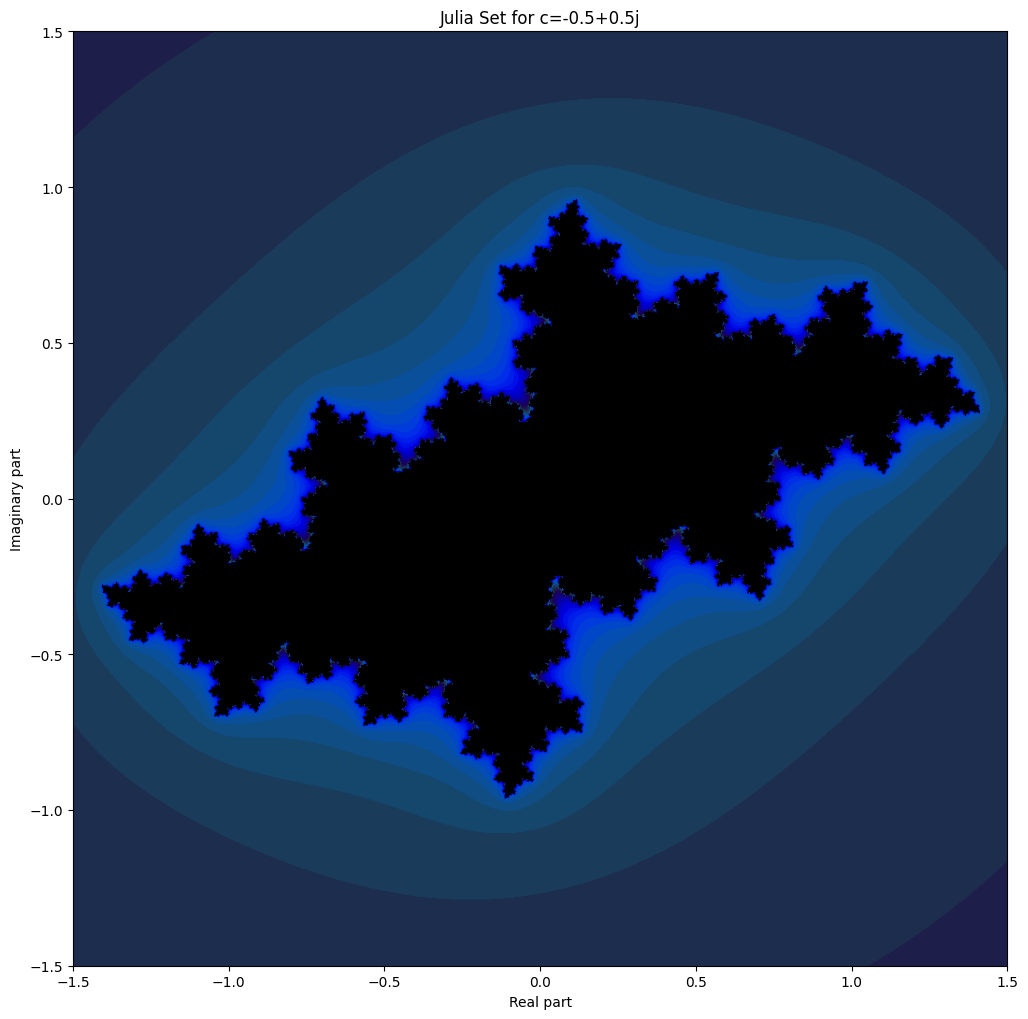

In [17]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

x_min, x_max = -1.5, 1.5
y_min, y_max = -1.5, 1.5

# fixed complex number c that defines the Julia set.
c_real = -0.5
c_imaginary = 0.5

max_iter = 500


Y, X = np.mgrid[y_min:y_max:0.003, x_min:x_max:0.003]

# Convert the NumPy arrays to PyTorch tensors and create the initial complex numbers.
z0_real = torch.Tensor(X)
z0_imag = torch.Tensor(Y)
zs = torch.complex(z0_real, z0_imag) # This is z_0 for each pixel

# Create the constant 'c' for the Julia set.
c = torch.complex(torch.tensor(c_real), torch.tensor(c_imaginary))

ns = torch.zeros_like(zs)

c = c.to(device)
zs = zs.to(device)
ns = ns.to(device)

for i in range(max_iter):
    #Compute the new values of z: z^2 + x
    zs_ = zs * zs + c
    #Have we diverged with this new value?
    not_diverged = torch.abs(zs_) < 4.0
    #Update variables to compute
    ns += not_diverged
    zs = zs_

#plot


import matplotlib.pyplot as plt
fig = plt.figure(figsize=(16,10))
def processFractal(a):
    """Display an array of iteration counts as a
    colorful picture of a fractal."""
    a_cyclic = (6.28*a/20.0).reshape(list(a.shape)+[1])
    img = np.concatenate([10+20*np.cos(a_cyclic),
    30+50*np.sin(a_cyclic),
    155-80*np.cos(a_cyclic)], 2)
    img[a==a.max()] = 0
    a = img
    a = np.uint8(np.clip(a, 0, 255))
    return a

plt.imshow(processFractal(ns.cpu().numpy()),  extent=[x_min, x_max, y_min, y_max])
# Add a title and labels.
plt.title(f"Julia Set for c={c_real}+{c_imaginary}j")
plt.xlabel("Real part")
plt.ylabel("Imaginary part")

# Display the plot.
plt.tight_layout(pad=0)
plt.show()


Computing a 3000x3000 Burning Ship fractal with 500 iterations...


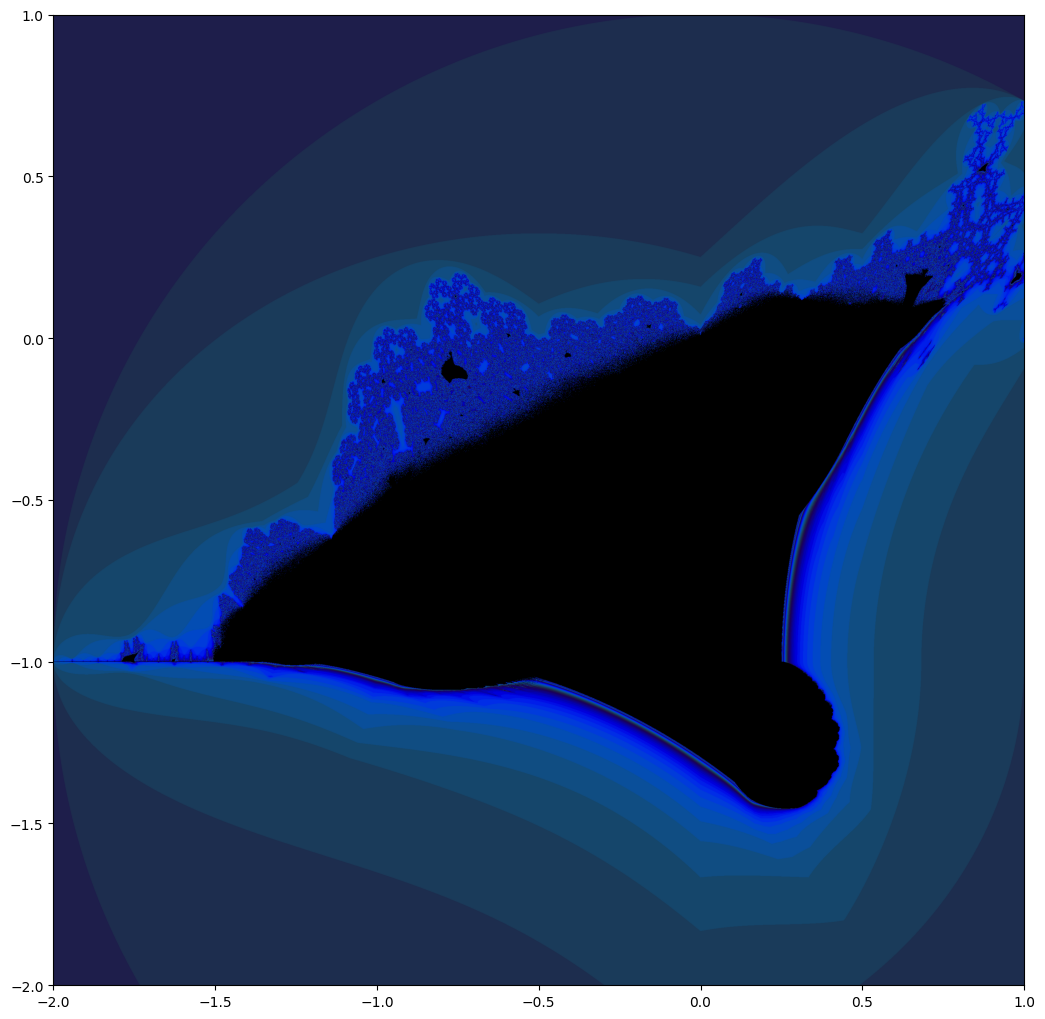

In [14]:
import torch
import numpy as np
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

x_min, x_max = -2.0, 1.0
y_min, y_max = -2.0, 1.0


# image res (higher for more detail, but slower)
width = 3000
height = 3000

# higher iterations capture more detail, but take longer and use more memory
max_iter = 500

# calc  step size based on the coord range and res.
x_step = (x_max - x_min) / width
y_step = (y_max - y_min) / height



Y, X = np.mgrid[y_min:y_max:y_step, x_min:x_max:x_step]


c_real = torch.Tensor(X)
c_imag = torch.Tensor(Y)
cs = torch.complex(c_real, c_imag)

zs = torch.zeros_like(cs)

# The counter for the "escape time".
ns = torch.zeros_like(cs, dtype=torch.float32)

# Move the tensors to the specified device for parallel computation.
cs = cs.to(device)
zs = zs.to(device)
ns = ns.to(device)

print(f"Computing a {width}x{height} Burning Ship fractal with {max_iter} iterations...")



for i in range(max_iter):
    # The core Burning Ship iteration: z_n+1 = (|real(z_n)| + i|imag(z_n)|)^2 + c
    #  computed in parallel for every pixel at once
    # take the  absval of the real and imaginary parts of z_n
    zs_abs_real = torch.abs(zs.real)
    zs_abs_imag = torch.abs(zs.imag)

    # Reconstruct the complex number and apply the standard iteration formula.
    zs_ = torch.complex(zs_abs_real, zs_abs_imag) ** 2 + cs

    mag_sq = zs_.real * zs_.real + zs_.imag * zs_.imag
    not_diverged = mag_sq < 4.0

    # Increment the counter for points that have not yet diverged.
    ns += not_diverged.to(torch.float32)

    # Update the working variable for the next iteration.
    zs = zs_

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(16,10))
def processFractal(a):
    """Display an array of iteration counts as a
    colorful picture of a fractal."""
    a_cyclic = (6.28*a/20.0).reshape(list(a.shape)+[1])
    img = np.concatenate([10+20*np.cos(a_cyclic),
    30+50*np.sin(a_cyclic),
    155-80*np.cos(a_cyclic)], 2)
    img[a==a.max()] = 0
    a = img
    a = np.uint8(np.clip(a, 0, 255))
    return a

plt.imshow(processFractal(ns.cpu().numpy()),  extent=[x_min, x_max, y_min, y_max])
plt.tight_layout(pad=0)
plt.show()

